In [11]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.datasets import ImageFolder
import albumentations as A
import torchvision
# # Load CLIP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
import cv2
from segment_anything import build_sam, SamAutomaticMaskGenerator, sam_model_registry
from PIL import Image, ImageDraw
import clip
import torch
import numpy as np

In [5]:
transform = A.Compose(
        [
            A.Resize(224, 224, always_apply=True),
            A.Normalize(max_pixel_value=255.0, always_apply=True),
        ]
    )

In [35]:
# Set the path to your dataset folder
dataset_path = '/scratch/sg7729/DL_project/SLIP/Evaluate/stitched_images'


In [9]:
df = pd.read_csv('/scratch/sg7729/DL_project/SLIP/Evaluate/stitched_images/stitched_images.csv')

In [12]:
sam_checkpoint = "/scratch/sg7729/DL_project/SLIP/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
      (1): Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, b

In [13]:
# Download the model weights to load them here
mask_generator = SamAutomaticMaskGenerator(
        model = sam,
        points_per_side = 16,
        pred_iou_thresh =  0.9,
        min_mask_region_area = 1,
        crop_overlap_ratio = 0.8 )

In [14]:
def convert_box_xywh_to_xyxy(box):
    x1 = box[0]
    y1 = box[1]
    x2 = box[0] + box[2]
    y2 = box[1] + box[3]
    return [x1, y1, x2, y2]

In [15]:
def segment_image(image, segmentation_mask):
    image_array = np.array(image)
    segmented_image_array = np.zeros_like(image_array)
    segmented_image_array[segmentation_mask] = image_array[segmentation_mask]
    segmented_image = Image.fromarray(segmented_image_array)
    black_image = Image.new("RGB", image.size, (0, 0, 0))
    transparency_mask = np.zeros_like(segmentation_mask, dtype=np.uint8)
    transparency_mask[segmentation_mask] = 255
    transparency_mask_image = Image.fromarray(transparency_mask, mode='L')
    black_image.paste(segmented_image, mask=transparency_mask_image)
    return black_image

In [16]:
def filter_annotations(annotations):
    annotations.sort(key=lambda x: x['area'], reverse=True)
    to_remove = set()
    for i in range(0, len(annotations)):
        a = annotations[i]
        for j in range(i + 1, len(annotations)):
            b = annotations[j]
            if i != j and j not in to_remove:
                # check if 
                if b['area'] < a['area']:
                    if (a['segmentation'] & b['segmentation']).sum() / b['segmentation'].sum() > 0.8:
                        # print('area')
                        to_remove.add(j)
#                         print(i, j)
#     print(to_remove)
    return [a for i, a in enumerate(annotations) if i not in to_remove]

In [26]:
# Load CLIP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:03<00:00, 96.9MiB/s]


In [44]:
@torch.no_grad()
def retrive(elements: list[Image.Image], search_text: str) -> int:
    preprocessed_images = [preprocess(image).to(device) for image in elements]
    tokenized_text = clip.tokenize([search_text]).to(device)
    stacked_images = torch.stack(preprocessed_images)
    image_features = model.encode_image(stacked_images)
    text_features = model.encode_text(tokenized_text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    probs = 100. * image_features @ text_features.T
    return probs[:, 0].softmax(dim=0)

In [45]:
def get_indices_of_values_above_threshold(values, threshold):
    return [i for i, v in enumerate(values) if v > threshold]

In [27]:
dataset_resnet = torchvision.datasets.ImageFolder(root='/scratch/sg7729/DL_project/SLIP/extra_dataest/dataset/', transform=transform)

In [28]:
resnet_model = torchvision.models.resnet18(pretrained=False)
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, len(dataset_resnet.classes))


/ext3/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/ext3/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [30]:

resnet_model.load_state_dict(torch.load('/scratch/sg7729/DL_project/SLIP/Classifier/resnet1876.17260787992495.pth'))

<All keys matched successfully>

In [62]:
# Define the transformation to be applied to each image
resnet_transform = transforms.Compose(
    [transforms.Resize((224, 224)),  # Resize the image to 224x224
     transforms.ToTensor(),  # Convert the image to a PyTorch tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # Normalize the image

In [42]:
pokedex = pd.read_csv('/scratch/sg7729/DL_project/SLIP/Evaluate/pokedex.csv')

In [73]:
images = df['images'].tolist()
class_list = df['classes'].tolist()
correct = 0
wrong = []
counter = 0
for i, image in enumerate(images):
    
    image_path = dataset_path + '/' + image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    masks = mask_generator.generate(img)
    annotations =  masks
    new_annotaions = filter_annotations(annotations)
    new_annotaions.pop(0)
#     print(len(masks))
    image = Image.open(image_path)
    cropped_boxes = []
    masks = new_annotaions
#     print(len(masks))
    for mask in new_annotaions:
        cropped_boxes.append(segment_image(image, mask["segmentation"]).crop(convert_box_xywh_to_xyxy(mask["bbox"])))

    classes_paths = class_list[i].split('_')
    classes_paths.pop()
    classes = []

    for c in classes_paths:
        index = c.split('/')[-1]
        if "-" in index:
            index = index.split('-')[0]
        index = index.split('.')[0]
        correct_label = list(pokedex[pokedex['Name'] == int(index)]['Type 1'])[0]
        classes.append(correct_label)
        
    for cl in classes:
        scores = retrive(cropped_boxes, cl)
        max_idx = torch.argmax(scores)
        predicted_segment = cropped_boxes[max_idx]
        transformed_segment =  resnet_transform(predicted_segment)
        transformed_segment =  transformed_segment.view(1, 3, 224, 224)
        resnet_model.eval()
        with torch.no_grad():
            predicted_resnet_label = resnet_model(transformed_segment)
            predicted_resnet_label = torch.argmax(predicted_resnet_label)
            predicted_class = dataset_resnet.classes[predicted_resnet_label]
#         print(predicted_class, cl)
        counter += 1
    if predicted_class.lower() == cl.lower():
        correct += 1
    else:
        wrong.append(predicted_segment)

    if counter % 50 == 0:
        accuracy = correct / counter
        print(f"Accuracy after {counter} images: {accuracy}")
print(f"Final accuracy: {correct / counter}")


Accuracy after 100 images: 0.17
Accuracy after 200 images: 0.175
Accuracy after 300 images: 0.16333333333333333
Accuracy after 400 images: 0.1525
Final accuracy: 0.1525


In [81]:
cl

'Gastly'

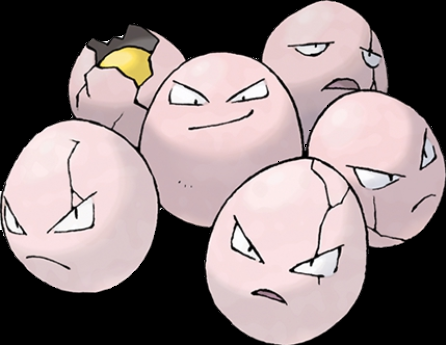

In [80]:
scores = retrive(cropped_boxes, cl)
max_idx = torch.argmax(scores)
predicted_segment = cropped_boxes[max_idx]
predicted_segment